# SPH Sampling

In [100]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from pyquaternion.quaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import PointCloud, LidarPointCloud, RadarPointCloud, Box
import numpy as np
import shutil
from PIL import Image
import os.path as osp
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
from matplotlib import cm



dataset_path = '/mnt/data/datasets/nuscenes/v1.0-mini/'
nusc = NuScenes(version='v1.0-mini', dataroot=dataset_path, verbose=True)
all_cam_strings = ['CAM_FRONT','CAM_FRONT_RIGHT','CAM_BACK_RIGHT','CAM_BACK','CAM_BACK_LEFT','CAM_FRONT_LEFT']
#all_cam_strings = ['CAM_FRONT_LEFT','CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
lidar_string = 'LIDAR_TOP'

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.438 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [127]:
def CreateGrid(bw):
    n_grid = 2 * bw
    k = 0;
    points = np.empty([2, n_grid, n_grid])
    for i in range(n_grid):
        for j in range(n_grid):
            points[0, i, j] = (np.pi*(2*i+1))/(4*bw)
            points[1, i, j] = (2*np.pi*j)/(2*bw);
            k = k + 1;
    return points

def createGrid_old(bw):
        n_grid = 2 * bw
        k = 0;
        points = np.empty([n_grid * n_grid, 2])
        for i in range(n_grid):
            for j in range(n_grid):
                points[k, 0] = (np.pi*(2*i+1))/(4*bw)
                points[k, 1] = (2*np.pi*j)/(2*bw);
                k = k + 1;
        return points

def ConvertGridToEuclidean(grid):
    cart_grid = np.zeros([3, grid.shape[1], grid.shape[2]])
    cart_grid[0,:,:] = np.multiply(np.sin(grid[0, :,:]), np.cos(grid[1,:,:]))
    cart_grid[1,:,:] = np.multiply(np.sin(grid[0, :, :]), np.sin(grid[1, :, :]))
    cart_grid[2,:,:] = np.cos(grid[0, :, :])    
    return cart_grid

def convertGridToEuclidean_old(grid):
    cart_grid = np.zeros([ grid.shape[0], 3])
    cart_grid[:,0] = np.multiply(np.sin(grid[:,0]), np.cos(grid[:,1]))
    cart_grid[:,1] = np.multiply(np.sin(grid[:,0]), np.sin(grid[:,1]))
    cart_grid[:,2] = np.cos(grid[:,0])    
    return cart_grid

def rgb_to_greyscale(r,g,b):
    return 0.2126*r + 0.7152*g + 0.0722*b

def transform_from_pcl_to_cam(nusc, pointsensor, cam, pc):
    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc

def transform_from_cam_to_pcl(nusc, pointsensor, cam, pc):
    # Transform from the camera into the vehicle's ego frame
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])    
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))
    
    # Transform from the ego frame (cam) to the global frame
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))
        
    # Transform from the global frame to the ego frame of the LiDAR.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])    
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)
        
    # Transform from the ego frame (LiDAR) to the LiDAR frame
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])    
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc

def project_pc_on_cam(pc, cam_intrinsics, depths):
    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], cam_intrinsics, normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    min_dist = 0.0001
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths < -1.0)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
    return points, mask

def sample_mono_from_image(im, pc, mask):
    n_mask = len(mask)
    #print(f"mask len is {n_mask}")
    for i in range(0,n_mask):    
        visible = mask[i]
        if not visible:
            continue
        cur_point = (points[0,i], points[1,i])    
        px = im.getpixel(cur_point)    
        intensity = rgb_to_greyscale(px[0], px[1], px[2])
        pc.points[3,i] = intensity
    return pc

def visualizeRawPointCloud(cloud, jupyter = False):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud[:, 0:3])
    colors = mapIntensityToRGB(cloud[:, 3])
    pcd.colors = o3d.utility.Vector3dVector(colors[:,0:3])

    if jupyter:
        self.__visualizeJupyter(pcd)
    else:
        o3d.visualization.draw_geometries([pcd])
        
def mapIntensityToRGB(i):
    return cm.jet(plt.Normalize(min(i), max(i))(i))

def writeRawPointCloud(cloud, filename):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud[:, 0:3])
    colors = mapIntensityToRGB(cloud[:, 3])
    pcd.colors = o3d.utility.Vector3dVector(colors[:,0:3])
    o3d.io.write_point_cloud(filename, pcd)

class SamplingPointCloud(PointCloud):

    @staticmethod
    def nbr_dims() -> int:
        """
        Returns the number of dimensions.
        :return: Number of dimensions.
        """
        return 4
    
    @classmethod
    def from_file(cls, file_name: str) -> 'SamplingPointCloud':
        return None
    
    @classmethod
    def from_bw(cls, bw) -> 'SamplingPointCloud':
        grid = createGrid_old(bw)
        xyz_grid = convertGridToEuclidean_old(grid) * 100
        intensities = np.zeros((xyz_grid.shape[0],1))
        sampling_grid = np.hstack((xyz_grid, np.ones((xyz_grid.shape[0], 1), dtype=xyz_grid.dtype)))
        return cls(sampling_grid.T)

In [129]:
print(f"We have {len(nusc.scene)} scenes in the dataset.")
#for scene in nusc.scene:
scene = nusc.scene[1]
first_sample_token = scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)
pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
pc = SamplingPointCloud.from_bw(300)

for cam_str in all_cam_strings:  
    print(f"Sampling for cam {cam_str}")
    cam = nusc.get('sample_data', sample['data'][cam_str])
    im = Image.open(osp.join(dataset_path, cam['filename']))    

    # Transform pointcloud into the camera frame
    pc = transform_from_pcl_to_cam(nusc, pointsensor, cam, pc)
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]
    print(f"depths {depths[1:20]}")

    # Project the points onto the image plane
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    intrinsics = np.array(cs_record['camera_intrinsic'])
    points, mask = project_pc_on_cam(pc, intrinsics, depths)
    filtered_points = points[:, mask]

    # Sample the intensity values from the image
    pc = sample_mono_from_image(im, pc, mask)    
    
    # Transform back into the LiDAR frame
    pc = transform_from_cam_to_pcl(nusc, pointsensor, cam, pc)
    #visualizeRawPointCloud(pc.points.T)
        
visualizeRawPointCloud(pc.points.T)

We have 10 scenes in the dataset.
Sampling for cam CAM_FRONT
depths [4.97667058 4.9794081  4.98214535 4.98488204 4.98761786 4.99035252
 4.99308571 4.99581714 4.9985465  5.0012735  5.00399784 5.00671922
 5.00943734 5.0121519  5.01486261 5.01756916 5.02027127 5.02296863
 5.02566094]
Sampling for cam CAM_FRONT_RIGHT
depths [2.82786336 2.82929718 2.83070647 2.83209107 2.83345084 2.83478562
 2.83609527 2.83737965 2.8386386  2.839872   2.84107971 2.8422616
 2.84341754 2.84454739 2.84565105 2.84672838 2.84777926 2.84880359
 2.84980125]
Sampling for cam CAM_BACK_RIGHT
depths [-0.594778   -0.59586561 -0.59697951 -0.59811958 -0.5992857  -0.60047773
 -0.60169556 -0.60293903 -0.60420803 -0.6055024  -0.60682201 -0.60816671
 -0.60953636 -0.61093079 -0.61234987 -0.61379344 -0.61526133 -0.61675339
 -0.61826945]
Sampling for cam CAM_BACK
depths [-4.93164107 -4.93437973 -4.93711754 -4.93985421 -4.94258944 -4.94532294
 -4.94805439 -4.9507835  -4.95350997 -4.95623351 -4.95895381 -4.96167057
 -4.9643835  -

(-0.5, 1680.2064017966586, 944.6485474764246, -0.5)

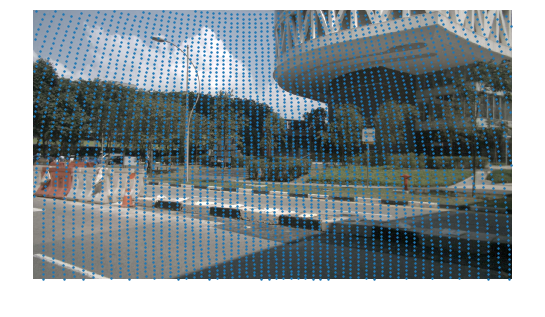

In [10]:
# Init axes.
dot_size = 2
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(im)
ax.scatter(filtered_points[0, :], filtered_points[1, :], s=dot_size)
ax.axis('off')

## Convert dataset to PLY

In [60]:
n_scenes = len(nusc.scene)
print(f"Processing {len(nusc.scene)} scenes in the dataset.")

for i in range(0, n_scenes):
    scene = nusc.scene[i]
    first_sample_token = scene['first_sample_token']
    sample = nusc.get('sample', first_sample_token)
    pointsensor = nusc.get('sample_data', sample['data'][lidar_string])
    pc = SamplingPointCloud.from_bw(200)

    for cam_str in all_cam_strings:  
        #print(f"Sampling for cam {cam_str}")
        cam = nusc.get('sample_data', sample['data'][cam_str])
        im = Image.open(osp.join(dataset_path, cam['filename']))    

        # Transform pointcloud into the camera frame
        pc = transform_from_pcl_to_cam(nusc, pointsensor, cam, pc)
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]

        # Project the points onto the image plane
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        intrinsics = np.array(cs_record['camera_intrinsic'])
        points, mask = project_pc_on_cam(pc, intrinsics, depths)
        filtered_points = points[:, mask]

        # Sample the intensity values from the image
        pc = sample_mono_from_image(im, pc, mask)    

        # Transform back into the LiDAR frame
        pc = transform_from_cam_to_pcl(nusc, pointsensor, cam, pc)
        #visualizeRawPointCloud(pc.points.T)
        
        filename = f"./dataset/cloud{i}.ply"
        writeRawPointCloud(pc.points.T, filename)

Processing 10 scenes in the dataset.
